<a href="https://colab.research.google.com/github/catherineabcde/Generative-AI-Text-and-Image-Synthesis/blob/main/Week%202%20MNIST%20hand-written%20digit%20recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **<font color="#0000FF">打造 AI 手寫辨識模型（Week 2 作業）</font>**


### 1. 讀入套件

In [ ]:
!pip install gradio -q

In [ ]:
%matplotlib inline

# 標準數據分析、畫圖套件
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 神經網路模型
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# 互動設計元件
from ipywidgets import interact_manual

# 網頁應用框架
import gradio as gr

### 1.1 由 Keras 讀入 MNIST

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### 1.2 切割驗證集 (validation set)
由於總訓練資料只有 60000 筆，因此切割其中的 10,000 筆資料作為驗證集。

In [ ]:
# 打亂順序以避免偏差
idx = np.arange(len(x_train))
rng = np.random.default_rng(42)
rng.shuffle(idx)
x_train, y_train = x_train[idx], y_train[idx]

# 切割資料
x_val, y_val = x_train[50000:], y_train[50000:]
x_train, y_train = x_train[:50000], y_train[:50000]

# 確認資料筆數是否正確
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

### 1.3 輸入格式整理

*   原本：28 * 28（二維）
*   後來：784（一維)

 > 註：/255: normalization，像素值原本範圍是 0～255，除以 255 後轉成 0～1 的浮點數

In [ ]:
x_train = x_train.reshape(50000, 784)/255
x_val = x_val.reshape(10000, 784)/255
x_test = x_test.reshape(10000, 784)/25

## 2. 建構標準神經網路
函數：
$$\hat{f} \colon \mathbb{R}^{784} \to \mathbb{R}^{10}$$

在嘗試不同設定時，我依據以下順序進行實驗：

*   神經網路層數
*   神經元數量
*   輸入層 / 隱藏層之 activation function
*   batch size / epoch 數量
*   optimizer / optimizer learning rate

每次更動一個影響因素來觀察模型表現，後面將會說明詳細的設定。





In [ ]:
model = Sequential()

### 2.2 設計神經網路的層數與各層神經元數量

In [ ]:
N1 = 100
N2 = 100
N3 = 100
N4 = 100
N5 = 100
# N6 = 100
# N7 = 100
# N8 = 100
# N9 = 100
# N10 = 100

在這裡我測試了以下幾種設定：

|            | 設定一 | 設定二 |設定三 |設定四 |
|------------|---|---|---|----|
| 神經網路層數 | 5 | 5 | 5 | 10 |
| 神經元數量 | 20/20/20/20/20 | 50/50/50/50/50 | 100/100/100/100/100 | 100/100/100/100/100/100/100/100/100/100 |


最後的結果是層數為 5、每層神經元 100 個的表現最佳。

> <font color='grey'>認為深一點的模型應該會表現比較好，但結果顯示卻與想像不同，但因為是在未調整其他設置的情況下測試，所以認為如果調整其他的參數也許能在 10 層的情況下獲得比 5 層更好的表現。</font>

In [ ]:
# 輸入層
model.add(Dense(N1, input_dim=784, activation='relu'))

# 隱藏層
model.add(Dense(N2, activation='relu'))
model.add(Dense(N3, activation='relu'))
model.add(Dense(N4, activation='relu'))
model.add(Dense(N5, activation='relu'))
# model.add(Dense(N6, activation='relu'))
# model.add(Dense(N7, activation='relu'))
# model.add(Dense(N8, activation='relu'))
# model.add(Dense(N9, activation='relu'))
# model.add(Dense(N10, activation='relu'))

# 輸出層
model.add(Dense(10, activation='softmax'))

#### **Activation Function**
在這裡，我分別嘗試了 <font color='orange'>ReLu</font> 與 <font color='orange'>tanh</font> 作為 activation function，雖然函數性質 ReLu 理論上與實作上都會表現比較好，但沒有使用過 tanh 所以也想嘗試看看。最終結果 tanh 的測試也有很好的表現，但相較之下使用 ReLu 仍表現較好，因此最後還是選擇 ReLu。
> 參考資料：[Activation Functions — Sigmoid & ReLu & tahn]('https://medium.com/@adea820616/activation-functions-sigmoid-relu-tahn-20e3ae726ae')

### 2.3 設定 loss function, optimizer, metric

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(learning_rate=0.087), metrics=['accuracy'])

#### **(1) Loss Function**

參考過去其他人在進行多分類任務時常用的 loss function，除了老師上課的範例 MSE，我嘗試了 <font color='4682B4'>sparse categorical cross entropy</font> 及 <font color='4682B4'>categorical cross entropy</font> 這兩種。

在使用 <font color='4682B4'>sparse categorical cross entropy</font> 作為損失函數時，因為處理資料的格式是整數標籤，因此去掉前面原先示範做的 one-hot encode (`to_categorical()`) 的操作。

> 參考資料：[【10】多分類問題下Sparse Cross Entropy 與Categorical Cross Entropy 的用法差異]('https://ithelp.ithome.com.tw/m/articles/10271081')

#### **(2) Optimizer**

這裡我嘗試了原本上課的範例 <font color='008000'>SGD</font>, <font color='008000'>Adam</font>，以及  <font color='008000'>SGD 搭配動態調整 learning rate 的 momentum 機制</font>這三種，經過不同 learning rate 的測試，最後得到最佳結果的設定是  <font color='008000'>SGD 加上 momentum (`learning rate=0.087, momentum=0.9`)</font>。

使用  <font color='008000'>Adam</font> 時，最初得到很糟糕的數據，所以詢問 chatgpt 可能的原因以及可以改善的方式，它提供給我的解釋是我的模型可能不夠大所以 accuracy 無法變好，另外就是 learning rate 的設定即使我有先降到一般最常使用的 0.001 還是太大，之後改成 0.0001 表現就真的有顯著提升。

以下是我嘗試的設定組合：
|           | <font color='red'>設定一</font> | 設定二 |設定三 |
|-----------|---|---|---|
| Optimizer | <font color='red'>SGD</font> | Adam | Adam |
| Optimizer Learning Rate | <font color='red'>0.087</font> | 0.001 | 0.0001 |

|           | 設定四 | 設定五 | 設定六 |
|-----------|---|---|---|
| Optimizer | SGD+momentum | SGD+momentum | SGD+momentum |
| Optimizer Learning Rate | 0.01+momentum=0.9 |0.03+momentum=0.9 | 0.04+momentum=0.9 | 0.086+momentum=0.9 |

|           | 設定七 |  設定八 | 設定九 |
|-----------|---|---|---|
| Optimizer | SGD+momentum | SGD+momentum</font> | SGD+momentum |
| Optimizer Learning Rate |0.086+momentum=0.9 | 0.087+momentum=0.9 | 0.088+momentum=0.9 |

其中以紅色標示之設定表現最好。

> 在嘗試不同的參數組合時，有試著將神經網路的層數調大，結果雖然還是沒有五層的表現好，但相較於先前沒有做任何其他改動單純增加神經網路層數，10 層的表現也有相當大的改善。


## 3. 訓練

1.   這裡我加入 early-stopping 的機制，如果 loss 在訓練過程中沒有繼續下降就停止訓練，避免過擬合。
2.   追蹤模型的 checkpoints，儲存 accuracy 表現最好的模型 `best_model.h5`。

> 參考資料：[[Day 18] 回呼模組(2)：EarlyStopping - iT 邦幫忙]('https://ithelp.ithome.com.tw/m/articles/10361486')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(
        '/content/drive/MyDrive/Colab Notebooks/best_model.h5',
        save_best_only=True,
        monitor='val_accuracy')
]

history = model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=50,
    validation_data=(x_val, y_val),
    verbose=1,
    callbacks=callbacks
)

### 3.1 查看最佳結果

In [ ]:
import numpy as np

val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

best_epoch = np.argmax(val_acc)
print(f"最佳 epoch: {best_epoch+1}")
print(f"當時 val_loss: {val_loss[best_epoch]:.4f}")
print(f"最佳 val_accuracy: {val_acc[best_epoch]*100:.2f}%")

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Colab Notebooks/best_model.h5')

loss, acc = model.evaluate(x_test, y_test, verbose=1)
print(f"Test data loss: {loss:.4f}")
print(f"Test data accuracy: {acc*100:.2f}%")

最後結果雖然各組數字差距不大，為了驗證結果多次相同設定重跑之後，發現數字浮動精準度也會有 0 ~ 1% 的差距，這也是值得關注的地方。（因此上面留下來的結果與提供之所有參數設定 pdf 檔中的實驗結果略有不同，但仍是取多次實驗表現都最好的組合。）

## 4. 用 Streamlit 來展示結果

參考網路上的資源，發現 <font color='7B68EE'>Streamlit</font> 這個同樣可以展示模型結果的網頁應用介面，且更有彈性並得以延伸擴展，因此在此次作業中學習使用 <font color='7B68EE'>Streamlit</font>。
> 參考資料：[[機器學習]CNN學習MNIST 手寫英文字母資料，用網頁展現成果]('https://vocus.cc/article/6598c7fbfd89780001048780')

In [ ]:
!pip install streamlit -q
!pip install streamlit_drawable_canvas -q

In [ ]:
import streamlit as st
from streamlit_drawable_canvas import st_canvas
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize

In [ ]:
# 載入模型
model = load_model('/content/drive/MyDrive/Colab Notebooks/best_model.h5')
model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(learning_rate=0.087), metrics=['accuracy'])

# 設計介面文字
st.set_page_config(page_title="MNIST 手寫文字辨識", page_icon="🎨", layout="centered")
col1, col2 = st.columns(2)

# 創建畫布
with col1:
    canvas_result = st_canvas(
        fill_color="rgba(0, 0, 0, 1)",
        stroke_width=10,
        stroke_color="rgba(0, 0, 0, 1)",
        update_streamlit=True,
        width=280,
        height=280,
        drawing_mode="freedraw",
        key="canvas1",
    )

with col2:
    if st.button('辨識'):

        image1 = rgb2gray(rgba2rgb(canvas_result.image_data))
        image_resized = resize(image1, (28, 28), anti_aliasing=True)

        X1 = 1 - image_resized
        X1 = X1.reshape(1,784)

        st.write("predict...")
        prediction = model.predict(X1).flatten()
        pred = int(np.argmax(prediction, axis=-1)[0])
        st.write(f'{pred}')
        st.image(image_resized)

In [ ]:
!streamlit run '/content/drive/MyDrive/Colab Notebooks/app.py'

由於在 colab 中無法成功執行，我詢問 chatgpt 這個原因，chatgpt 建議我使用本機的終端機來執行這段程式，因此我將上述的程式碼寫成一個 app.py 檔，利用終端機來跑，可以成功顯示網頁與進行辨識，截圖如下所示：

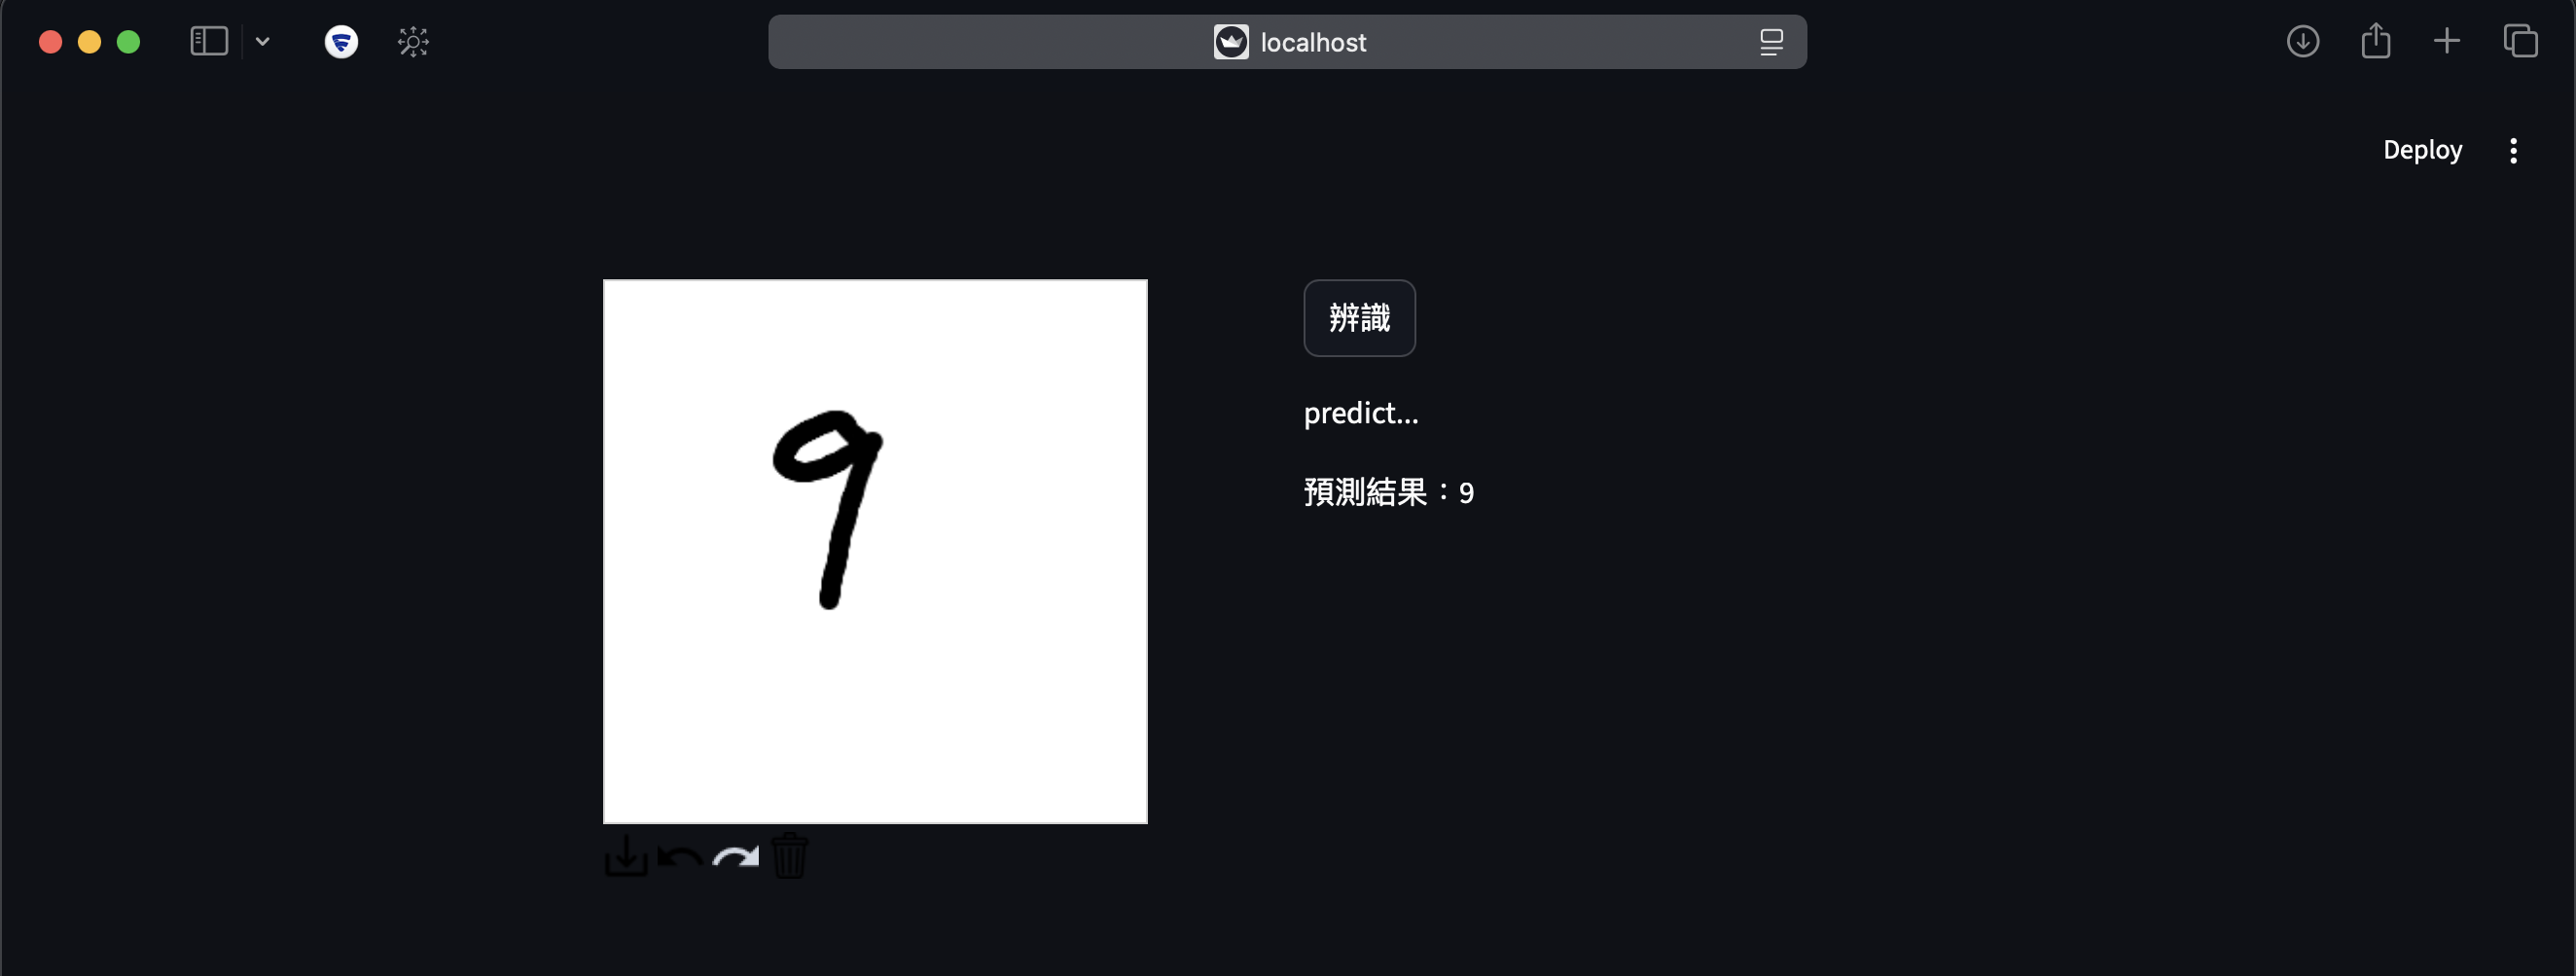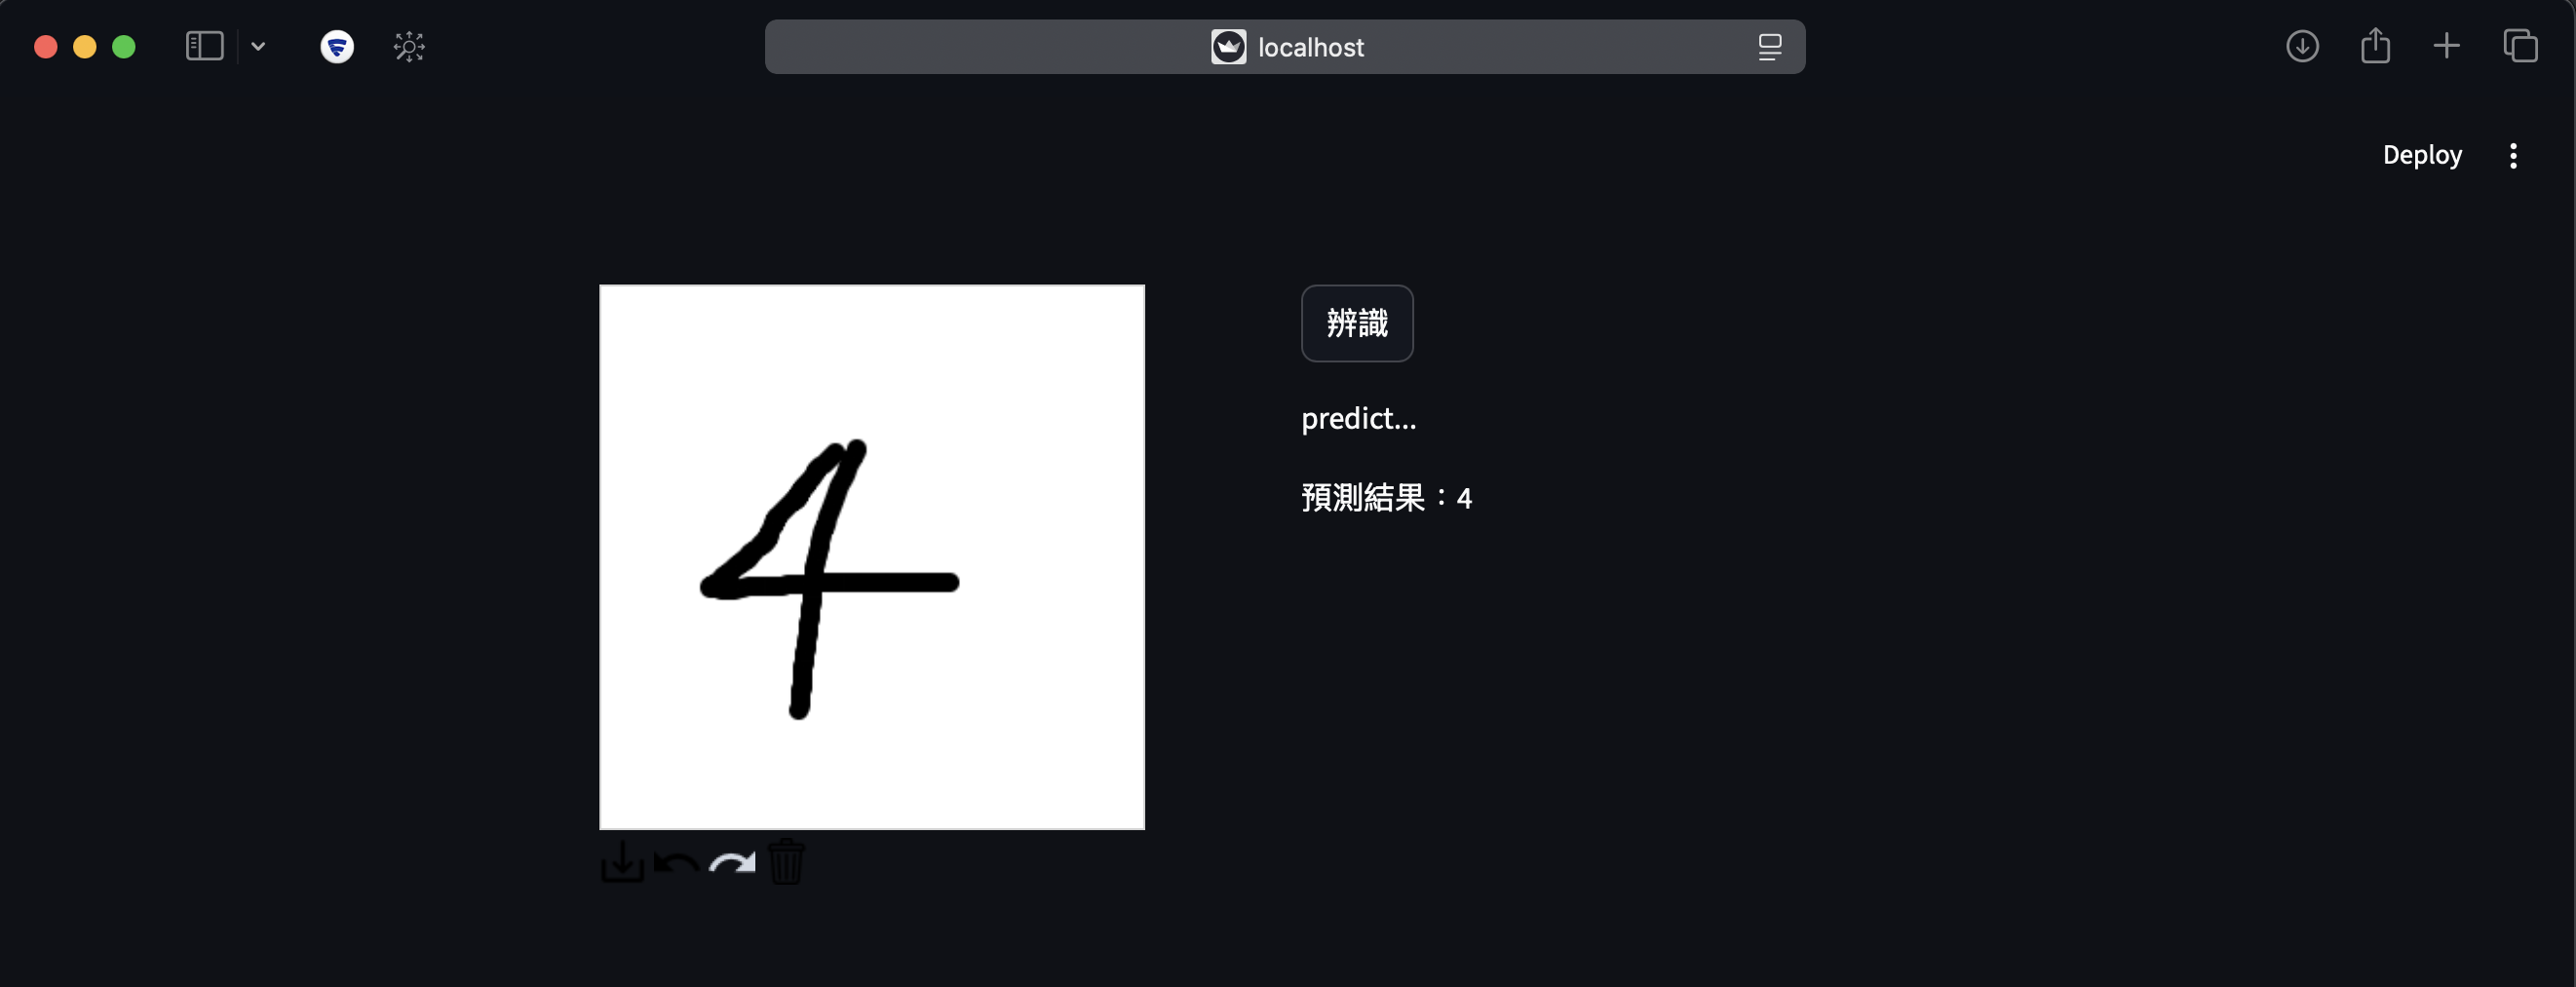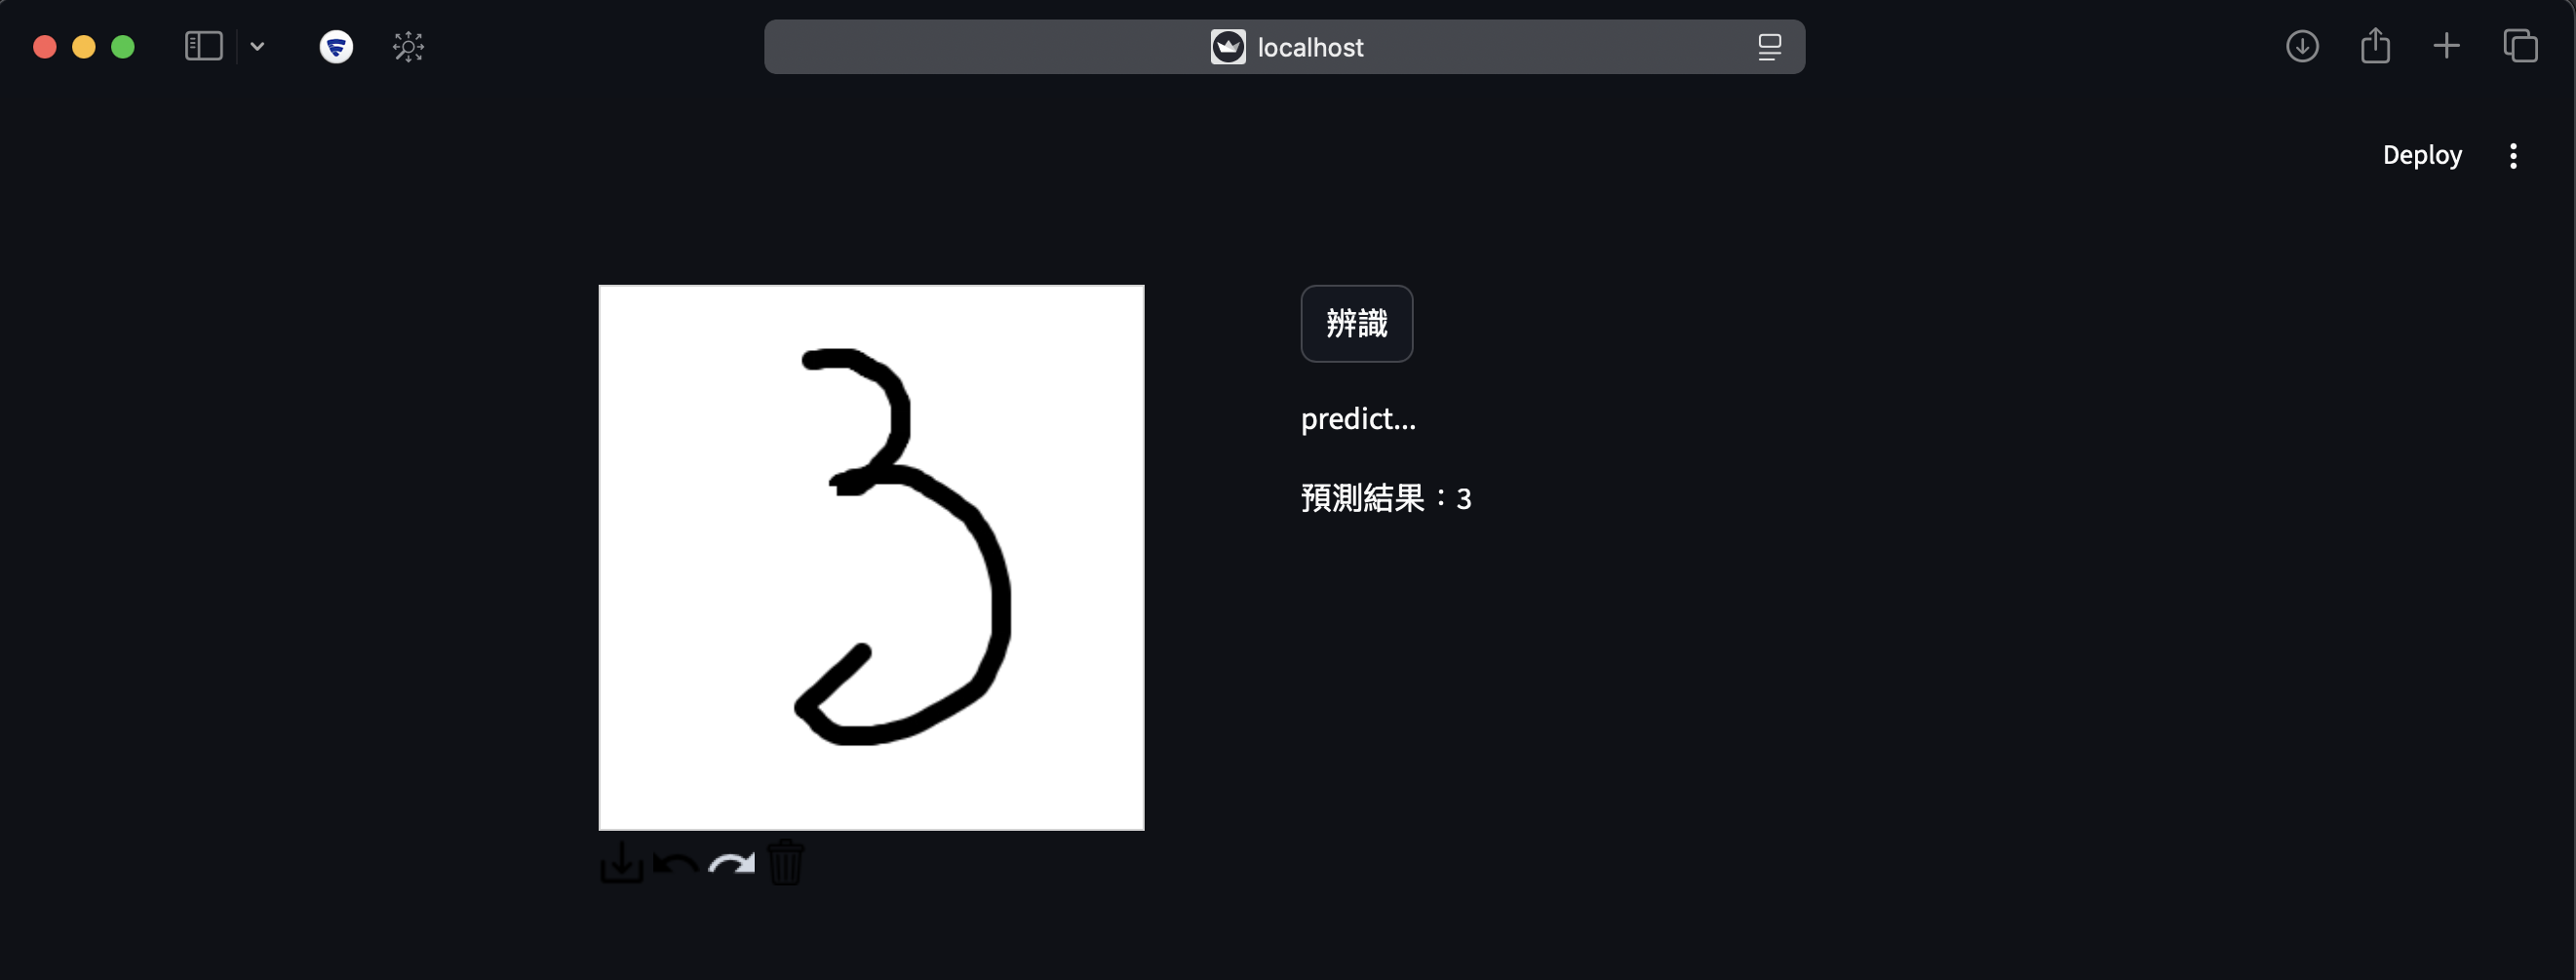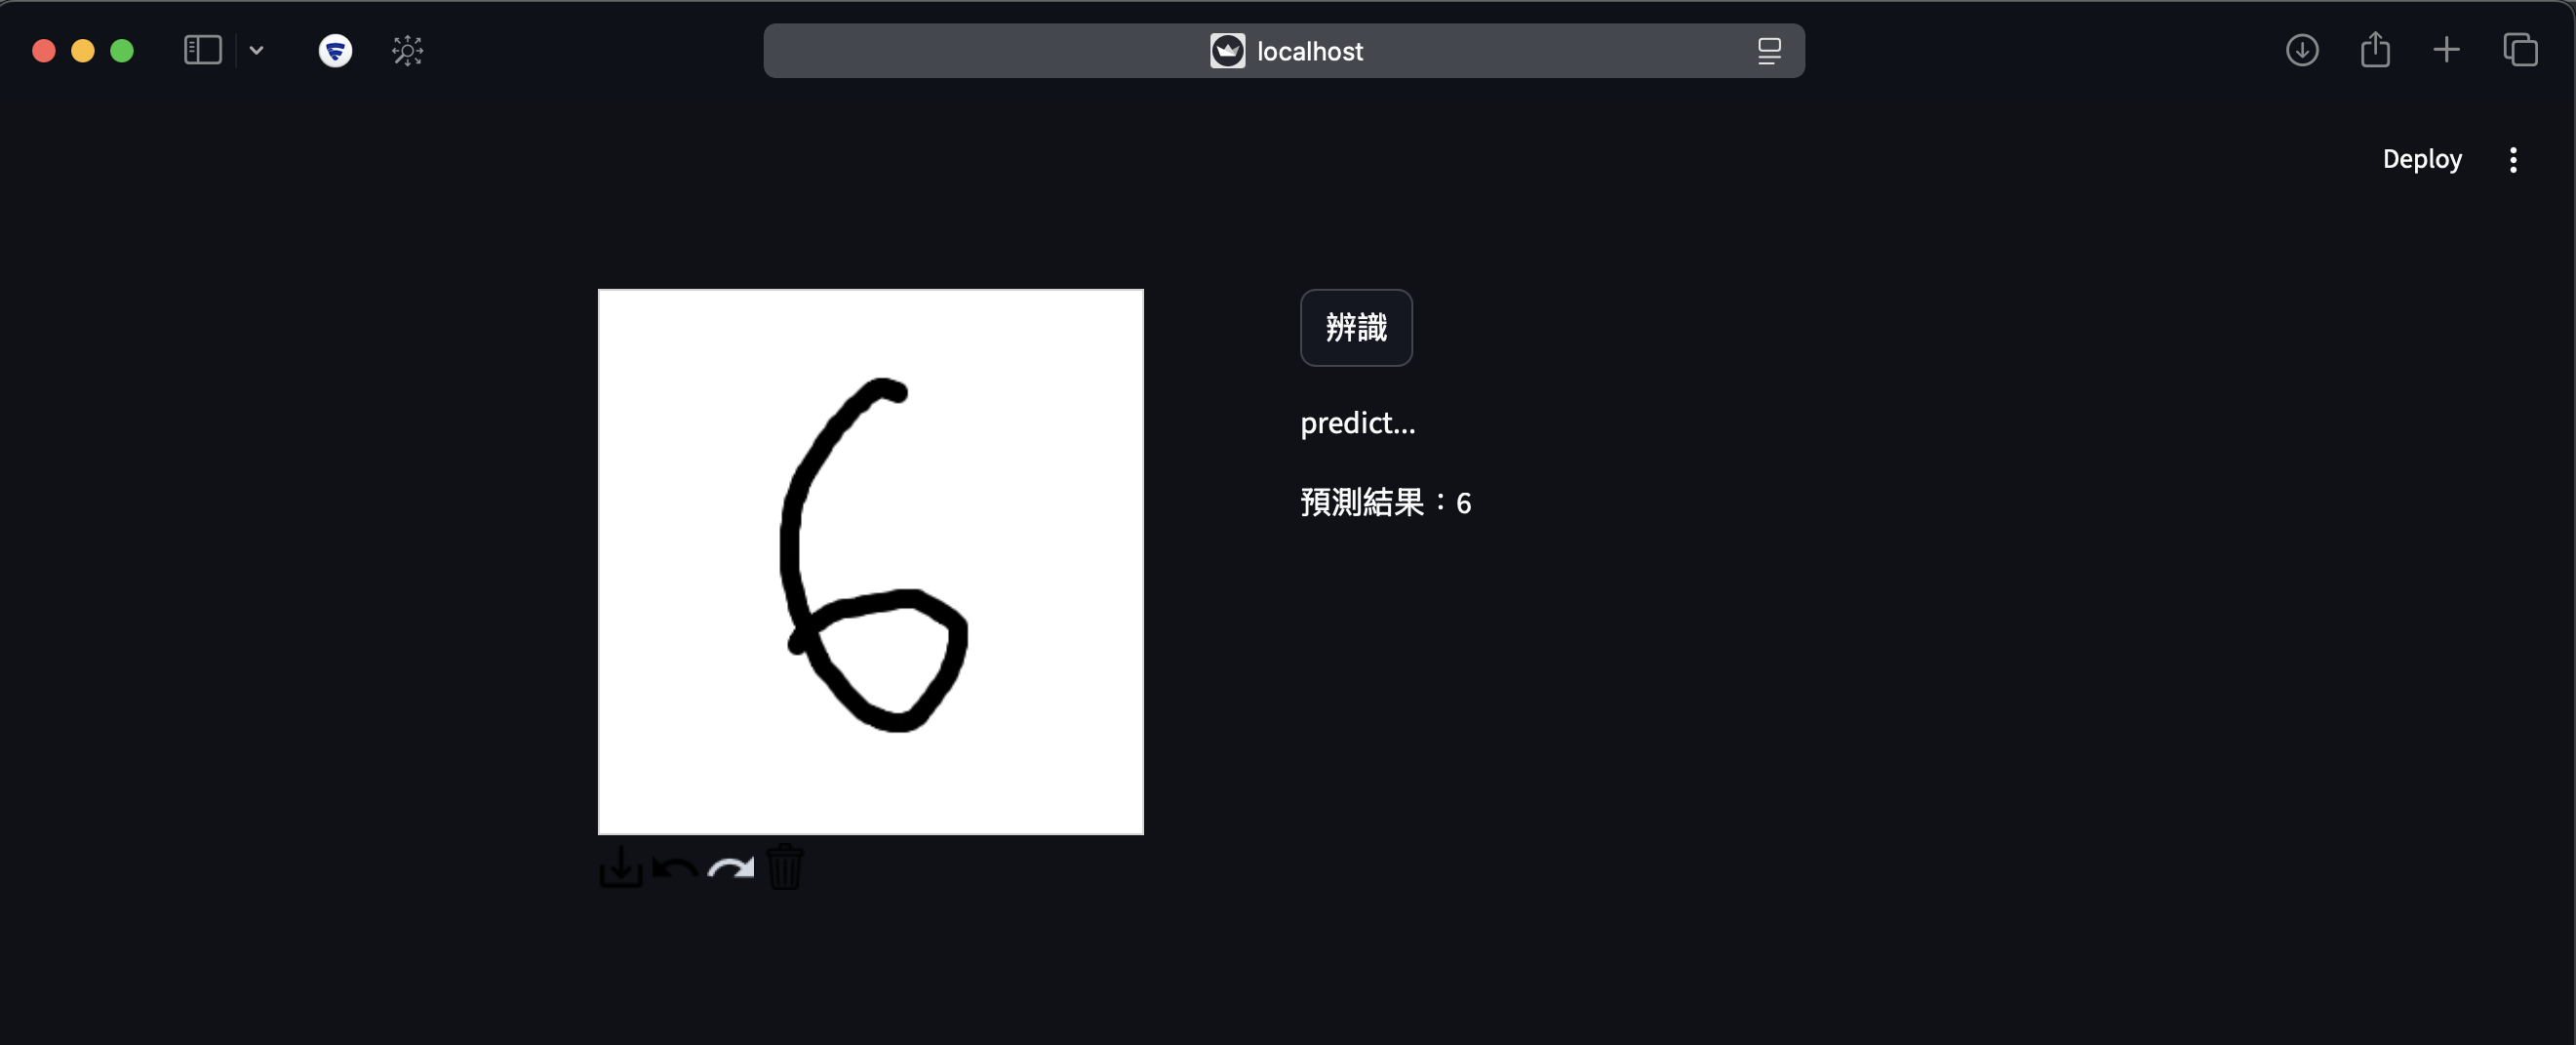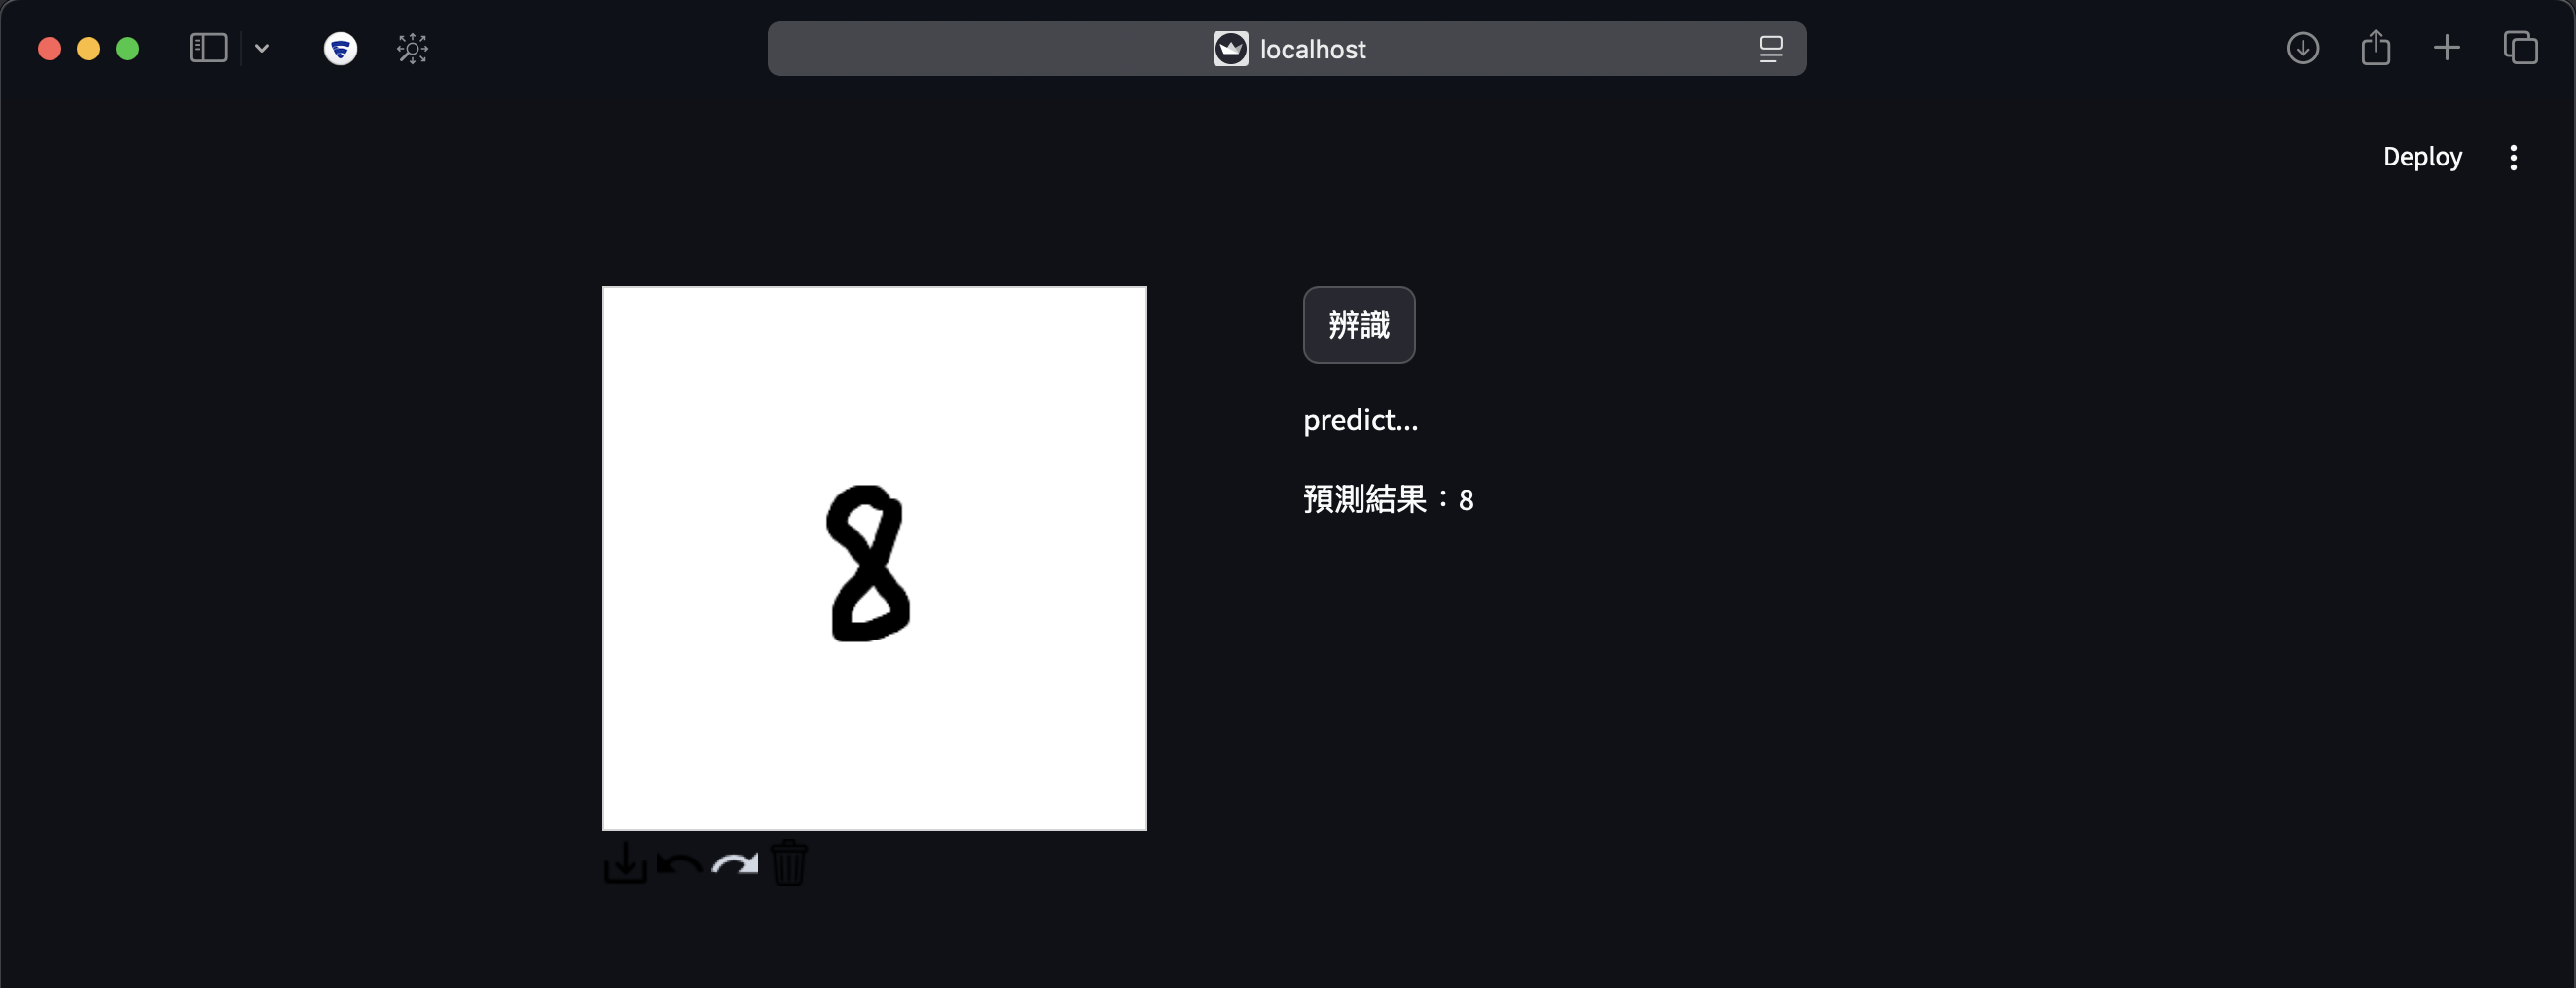

我在終端機執行的程式為以下檔案：
[app.py]('https://drive.google.com/file/d/1mkQTxGVUPM3HxkKt322lipfNpUymuzwm/view?usp=sharing')

* `tensorflow`
* `numpy`
* `streamlit`
* `streamlit_drawable_canvas`

下面這段程式碼即 app.py 中的內容，在執行的過程遇到還沒成功載入網頁就會自動中斷的情況，因此我也問 chatgpt 這個可能的原因，他告訴我可能是因為 <font color='red'>macOS + TensorFlow / OpenMP 在 Streamlit 內部執行時的原生程式庫衝突（執行緒/鎖）造成的崩潰</font>。其中，他提供給我的解決方法是把 TF 的載入與執行方式調整成更保守、限制執行緒數、避免重複載入，以及關閉某些最佳化這些操作。

以下前後有用 5 個 <font color='2E8857'>#</font> 框住的部分即 chatgpt 提供給我的解決方法。

雖然 Streamlit 在閱讀的文章中都顯示較 Gradio 更強大，但在實作的過程中覺得以小型任務來說也許 Gradio 更為方便。

In [ ]:
#####
import os

# 避免 OpenMP/OneDNN 在 macOS 下與 Streamlit 互斥鎖衝突
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["TF_NUM_INTEROP_THREADS"] = "1"
os.environ["TF_NUM_INTRAOP_THREADS"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
#####

import numpy as np

import streamlit as st
from streamlit_drawable_canvas import st_canvas
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize

#####
@st.cache_resource(show_spinner="Loading model...")
def load_tf_model():
    # 延後 import，降低啟動時機造成的原生衝突
    from tensorflow.keras.models import load_model
    m = load_model("best_model.h5")
    return m
#####

model = load_tf_model()

# 設計介面文字
st.set_page_config(page_title="MNIST 手寫文字辨識", page_icon="🎨", layout="centered")
col1, col2 = st.columns(2)

# 創建畫布
with col1:
    canvas_result = st_canvas(
        fill_color="rgba(0, 0, 0, 1)",
        stroke_width=10,
        stroke_color="rgba(0, 0, 0, 1)",
        background_color="rgba(255, 255, 255, 1)",
        update_streamlit=True,
        width=280,
        height=280,
        drawing_mode="freedraw",
        key="canvas1",
    )

with col2:
    if st.button("辨識") and canvas_result.image_data is not None:

        image1 = rgb2gray(rgba2rgb(canvas_result.image_data))
        image_resized = resize(image1, (28, 28), anti_aliasing=True)

        X1 = 1.0 - image_resized
        X1 = X1.reshape(1, 784).astype("float32")

        st.write("predict...")
        prediction = model.predict(X1).flatten()
        pred = int(np.argmax(prediction))
        st.write(f"預測結果：{pred}")